In [6]:
from dataloader import AmazonDataset
import models
from models import DistMulti, TransE
from training import TrainIterater
from evaluate import Evaluater

import optuna
import numpy as np
import pickle

import torch
from importlib import reload

In [3]:
# ハイパラ
# 
# embed_dim
# batch_size
# weight_decay, lr, warmup, lr_decay_every, lr_decay_rate
# kg embed model
model_name = 'TransE'
dataset = AmazonDataset('./data', model_name='TransE')
def objective(trial):

    relation_size = len(set(list(dataset.triplet_df['relation'].values)))
    entity_size = len(dataset.entity_list)
    embedding_dim = trial.suggest_discrete_uniform('embedding_dim', 16, 128, 16)
    model = TransE(int(embedding_dim), relation_size, entity_size)
    
    batch_size = trial.suggest_int('batch_size', 128, 512, 128)
    iterater = TrainIterater(batch_size=int(batch_size), model_name=model_name)
    
    lr= trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    #warmup = trial.suggest_int('warmup', 100, 500)
    warmup = trial.suggest_int('warmup', 1, 5)
    lr_decay_every = trial.suggest_int('lr_decay_every', 1, 10)
    lr_decay_rate = trial.suggest_uniform('lr_decay_rate', 0.5, 1)
    
    score =iterater.iterate_epoch(model, lr=lr, epoch=20, weight_decay=weight_decay, warmup=warmup,
                           lr_decay_rate=lr_decay_rate, lr_decay_every=lr_decay_every, eval_every=10)
    
    return -1 * score

epoch: 9  precision: 0.011569157182817032
epoch: 19  precision: 0.019904005884591732


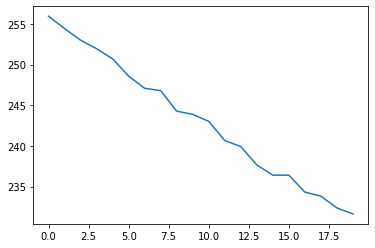

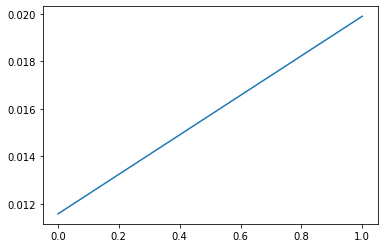

[I 2020-07-04 04:58:07,857] Finished trial#0 with value: -0.019904005884591732 with parameters: {'embedding_dim': 48.0, 'batch_size': 256, 'lr': 0.00027575703280897554, 'weight_decay': 0.008211142725366551, 'warmup': 5, 'lr_decay_every': 8, 'lr_decay_rate': 0.6785466714298021}. Best is trial#0 with value: -0.019904005884591732.


In [4]:
study = optuna.create_study()
study.optimize(objective, n_trials=1)

In [7]:
df = study.trials_dataframe() # pandasのDataFrame形式
df.to_csv('./hypara.csv')

In [8]:
# save best params 
with open('best_param.pickle', 'wb') as f:
    pickle.dump(study.best_params, f)

In [9]:
study.best_params

{'embedding_dim': 48.0,
 'batch_size': 256,
 'lr': 0.00027575703280897554,
 'weight_decay': 0.008211142725366551,
 'warmup': 5,
 'lr_decay_every': 8,
 'lr_decay_rate': 0.6785466714298021}